# 0.0 Imports

In [1]:
!pip install inflection

In [2]:
!pip install boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.8 MB/s eta 0:00:00


In [88]:
import numpy   as np
import pandas  as pd
import random  as rnd
import seaborn as sns
import xgboost as xgb
from google import colab as cl

import math
import json
import pickle

import warnings
import datetime
import requests
import inflection

from scipy      import stats  as ss
from matplotlib import pyplot as plt

from boruta                import BorutaPy
from tabulate              import tabulate
from IPython.display       import Image
from matplotlib.gridspec   import GridSpec
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from flask                 import Flask

# 0.1 Helper Functions

In [4]:
def cross_validation(x_training, kfold, model_name, model, verbose = False):

    # Lists to store results
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):

        # Verbose Mode
        if verbose:
            print(f'Kfold Number: {k}')

        # start and end for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation Dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model

        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error('Linear Regression', np.expm1(yvalidation), np.expm1(yhat))

        # store performance for each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({
        'Model Name': model_name,
        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])

In [5]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1)*(r - 1) / (n - 1))

    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (k - 1)**2 / (n - 1)

    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

In [6]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

In [7]:
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

In [8]:
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({
        'Model Name' : model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    }, index=[0])

In [9]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

# 0.2 Loading Data

In [11]:
file_upload=cl.files.upload()

Saving trainn.csv to trainn.csv


In [12]:
file_upload=cl.files.upload()

Saving store.csv to store.csv


In [13]:
file_upload=cl.files.upload()

Saving testt.csv to testt.csv


In [ ]:
file_upload=cl.files.upload()

Saving DAILY_STORE_SALES.png to DAILY_STORE_SALES.png


In [ ]:
file_upload=cl.files.upload()

In [14]:
df_sales_raw=pd.read_csv('trainn.csv', low_memory=False)
df_store_raw=pd.read_csv('store.csv', low_memory=False)

#merge
df_raw=pd.merge(df_sales_raw,df_store_raw, how='left', on='Store' )

In [ ]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
125644,765,5,2015-04-10,7878,692,1,0,0,1,a,c,25430.0,5.0,1999.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"


# 1.0 Data Description

In [15]:
df1=df_raw.copy()
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Columns Descriptions

**Id** - an Id that represents a (Store,Date) duple within the test set.

**Store** - a unique Id for each store.

**Sales** - the turnover for any given day (this is what you are predicting).

**Customers** - the number of customers on a given day.

**Open** - an indicator for whether the store was open: 0 = closed, 1 = open.

**StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None.

**SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools.

**StoreType** - differentiates between 4 different store models: a, b, c, d.

**Assortment** - describes an assortment level: a = basic, b = extra, c = extended.

**CompetitionDistance** - distance in meters to the nearest competitor store.

**CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened.

**Promo** - indicates whether a store is running a promo on that day.

**Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating.

**Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2.

**PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

## 1.2 Rename Columns

In [16]:
cols_old=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase= lambda x: inflection.underscore(x)

cols_new=list(map(snakecase,cols_old))

#rename
df1.columns= cols_new

## 1.3 Data dimension

In [17]:
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Columns: {df1.shape[1]}")

Number of Rows: 1017209
Number of Columns: 18


1.4 Data Type

In [ ]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [18]:
df1['date'] = pd.to_datetime(df1['date'])


## 1.5 Check NA

In [ ]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.6 Fillout NA

In [19]:
# competition Distance
df1['competition_distance'].max()

75860.0

In [20]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

In [21]:
# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

In [22]:
# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [23]:
# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

In [24]:
#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


In [25]:
# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [ ]:
# Checking NA
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

##1.7 Change Types*

In [ ]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [26]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [ ]:
# Checking Types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.8 Descriptive Statistics

### 1.8.1. Categorical and Numeric Separation

In [27]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.8.2. Numerical Attributes

In [28]:
# Central Tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

In [29]:
# Dispersion Tendency
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

In [30]:
# Dispersions Concatenation
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d6, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-1.200524,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,-1.246873,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,1.778375,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,7.091773,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,1.090723,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,-1.762018,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,0.815154,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,147.789712,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-1.232607,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,124.071304,124.071304


<ipython-input-41-c699e964c8f2>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1['competition_distance'], kde=False );


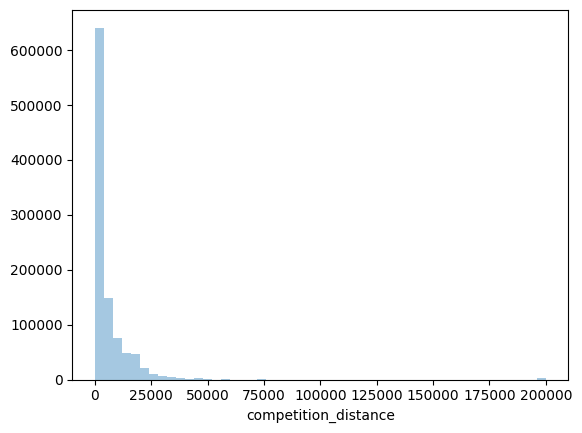

In [ ]:
sns.distplot( df1['competition_distance'], kde=False );

### 1.8.3 Categorical Attributes

In [31]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

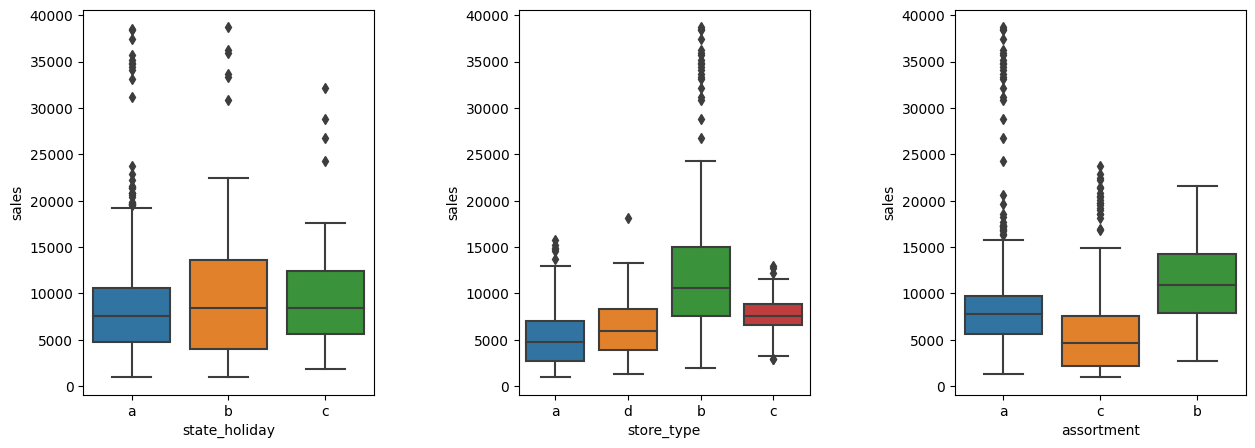

In [ ]:
plt.figure(figsize=(15, 5))
aux1=df1[(df1['state_holiday'] !='0' )& (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

plt.subplots_adjust(wspace=0.5)

plt.show()

2.0 FEATURE ENGINEERING

In [32]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

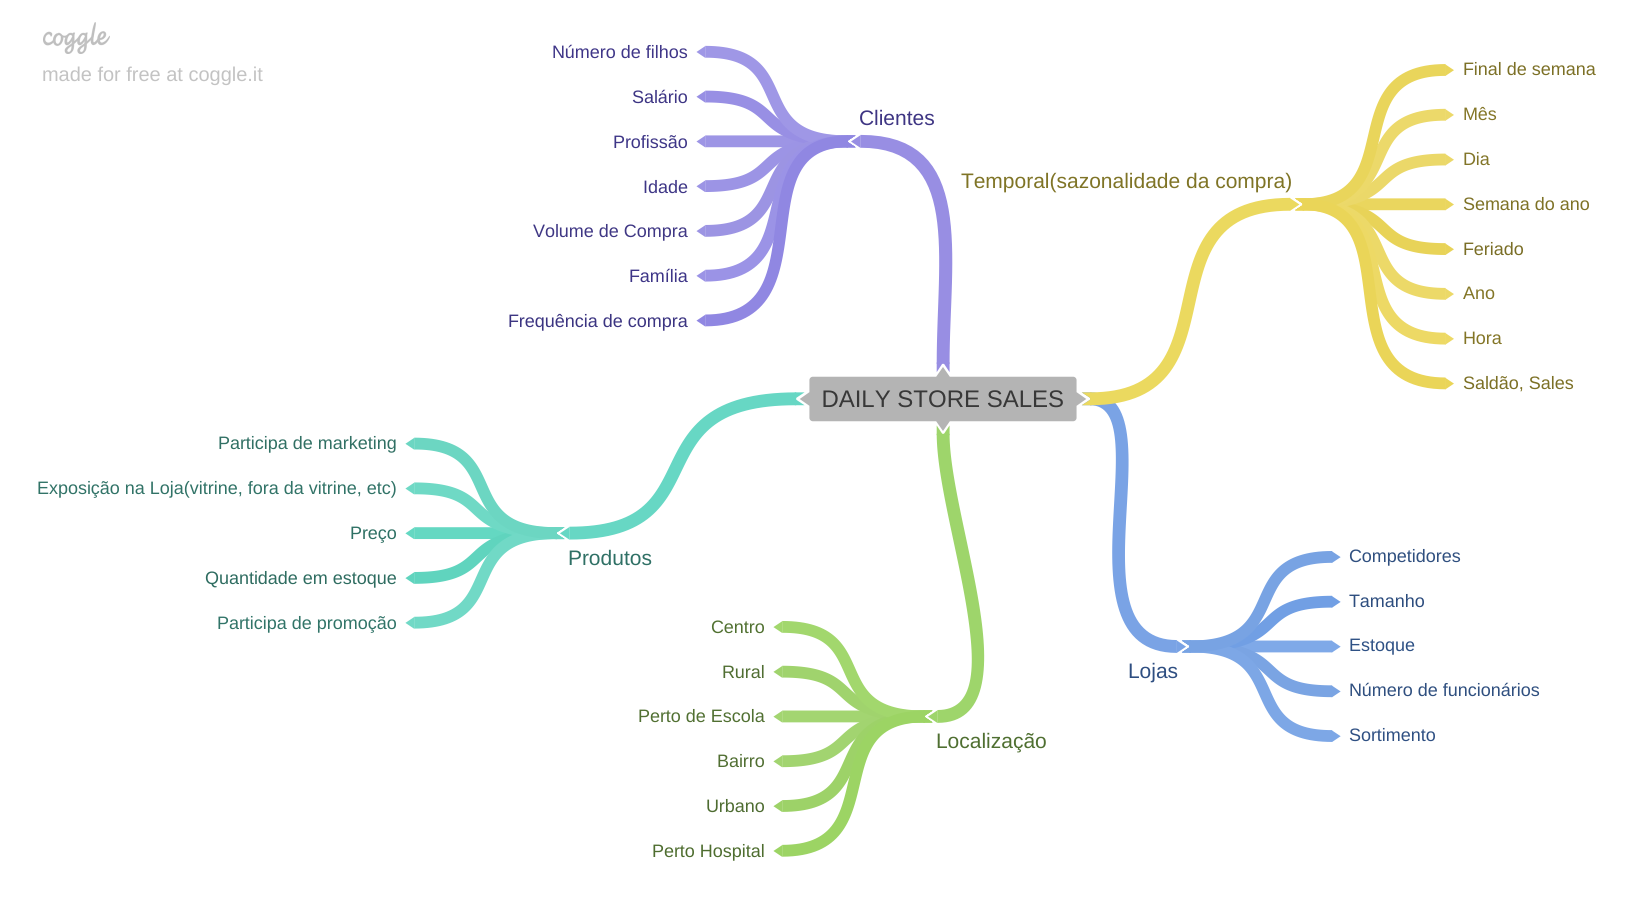

In [ ]:
Image("DAILY_STORE_SALES.png")

## 2.2. Hypotesis

1. Lojas com maior sortimento deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vender mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas durante o feriado do Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana.
12. Lojas deveriam vender menos durante os feriados escolares.
(HIPÓTESES QUE SERÃO VALIDADAS, AVALIAR A CORRELAÇÃO COM O FENOMOENO E A INFLUENCIA DA CORRELAÇÃO)

## 2.4. Feature Engineering

In [33]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

<ipython-input-33-72a7877af917>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0. FILTERING FEATURES

In [34]:
df3 = df2.copy()

## 3.1. Filtering Lines

In [35]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns Selection

In [36]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3.drop(cols_drop, axis=1, inplace=True)

# 4.0 EDA - EXPLORATORY DATA ANALYSIS

In [37]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

<ipython-input-44-67e6780506c1>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'])


<Axes: xlabel='sales', ylabel='Density'>

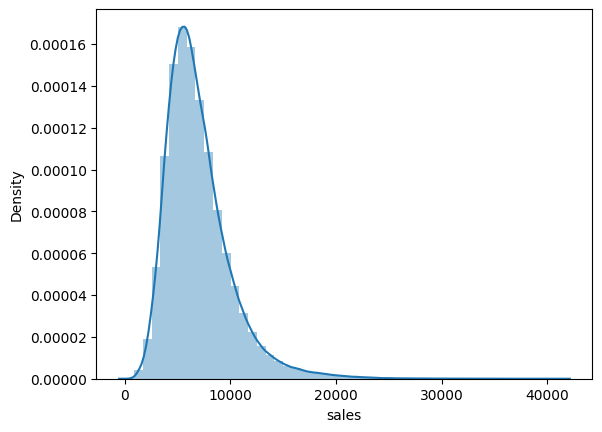

In [ ]:
sns.distplot(df4['sales'])


### 4.1.2. Numerical Variable

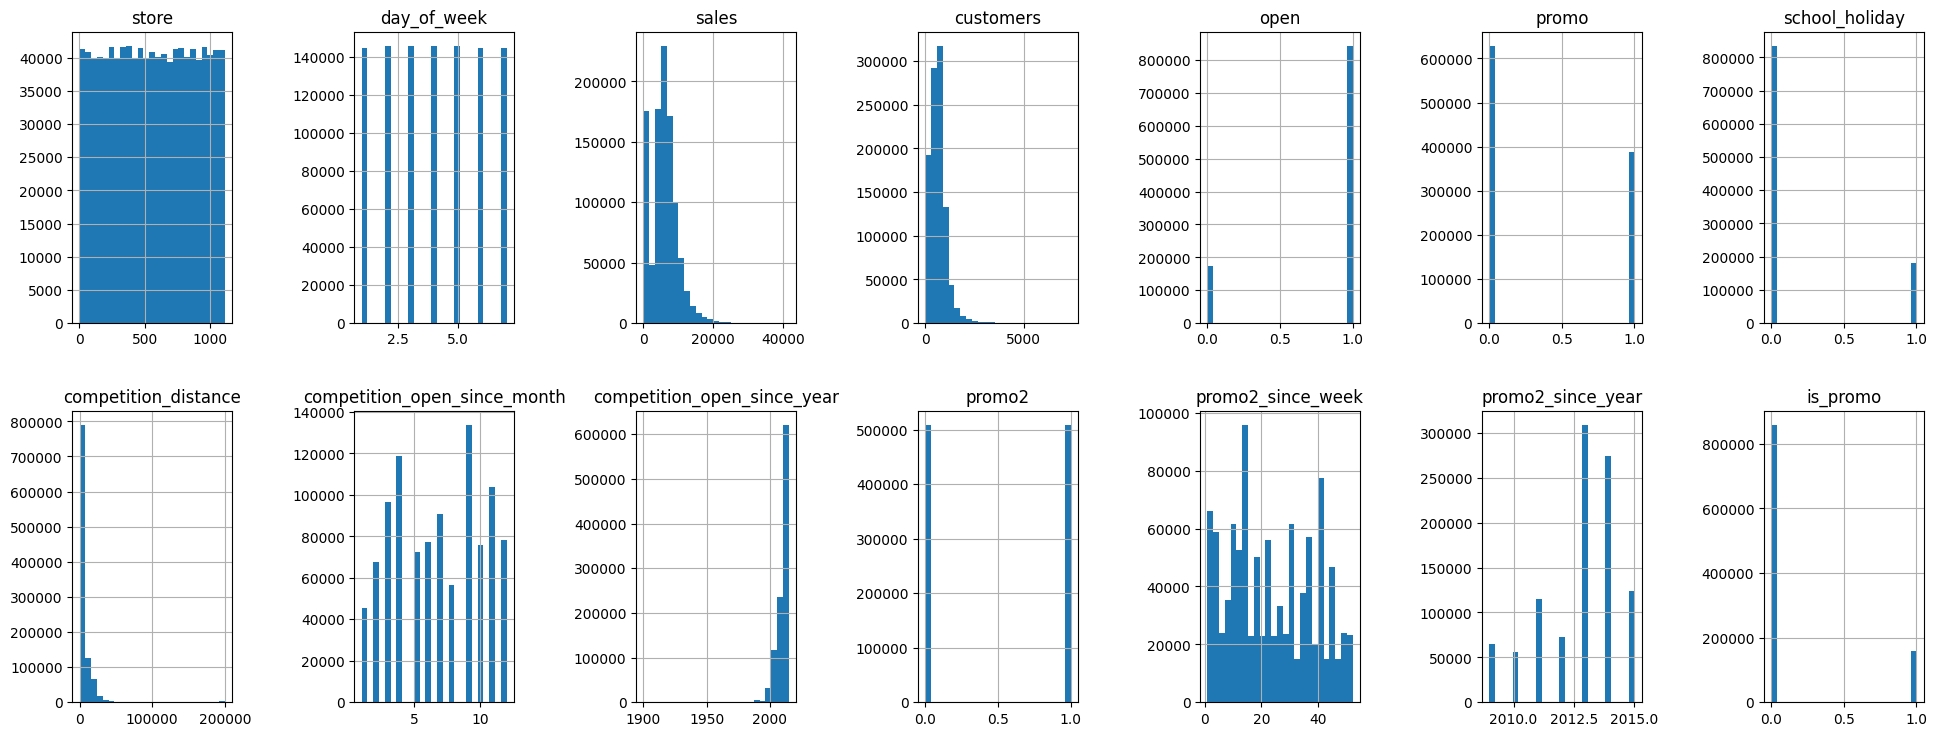

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(20, 8))
axes = axes.flatten()
num_attributes.hist(bins=25, ax=axes);
plt.tight_layout(pad=3.0)

### 4.1.3. Categorical Variables

In [ ]:
df4['state_holiday'].drop_duplicates()
df4['store_type'].drop_duplicates()
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<ipython-input-46-b0d95024f0c5>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True, ax=axes[0, 1])
<ipython-input-46-b0d95024f0c5>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True, ax=axes[0, 1])
<ipython-input-46-b0d95024f0c5>:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True, ax=axes[1, 1])
<ipython-input-46-b0d95024f0c5>:18: FutureWarning: 

`shade` is now deprecated in favor of 

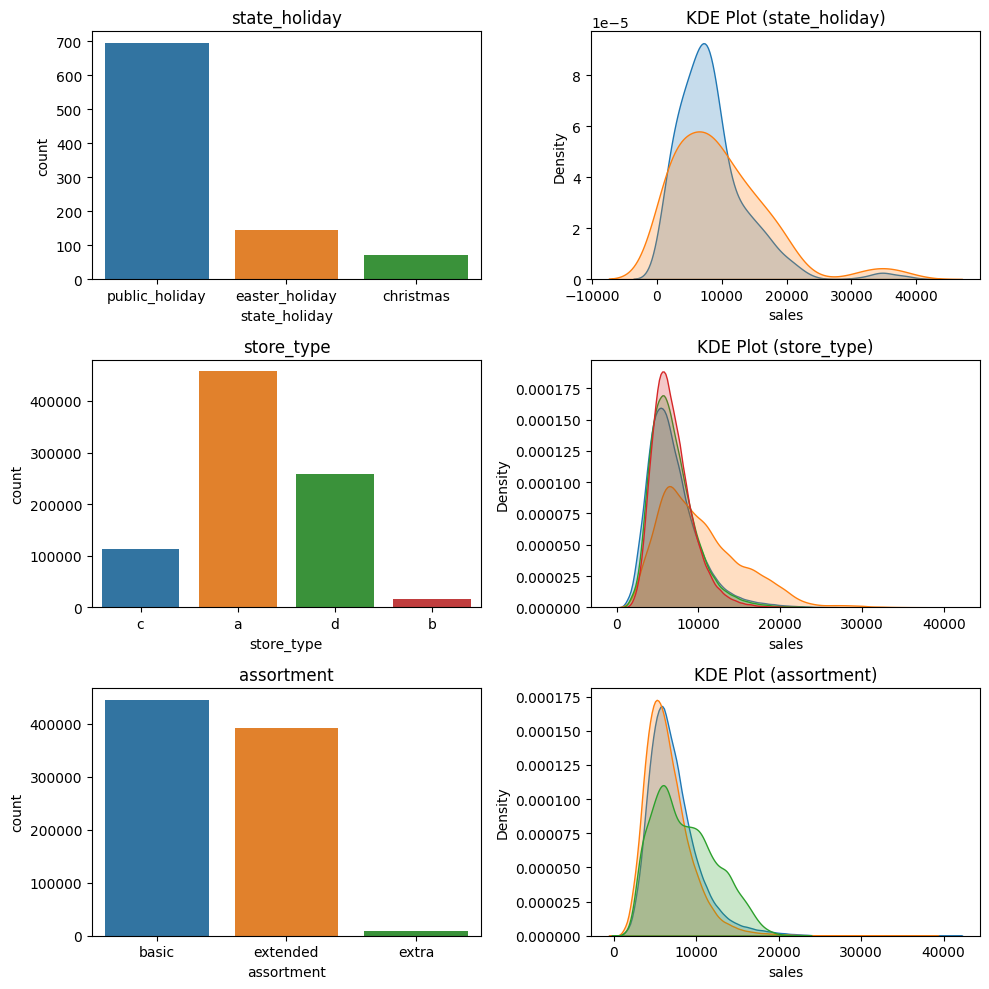

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

# state_holiday
axes[0, 0].set_title('state_holiday')
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data=a, x='state_holiday', ax=axes[0, 0])

axes[0, 1].set_title('KDE Plot (state_holiday)')
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True, ax=axes[0, 1])
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True, ax=axes[0, 1])

# store_type
axes[1, 0].set_title('store_type')
sns.countplot(data=df4, x='store_type', ax=axes[1, 0])

axes[1, 1].set_title('KDE Plot (store_type)')
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True, ax=axes[1, 1])
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True, ax=axes[1, 1])
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True, ax=axes[1, 1])
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True, ax=axes[1, 1])

# assortment
axes[2, 0].set_title('assortment')
sns.countplot(data=df4, x='assortment', ax=axes[2, 0])

axes[2, 1].set_title('KDE Plot (assortment)')
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True, ax=axes[2, 1])
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True, ax=axes[2, 1])
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True, ax=axes[2, 1])

plt.tight_layout()  # Remove as informações exibidas abaixo do código

plt.show()

## 4.2 Análise Bivariada

<Axes: xlabel='year_week'>

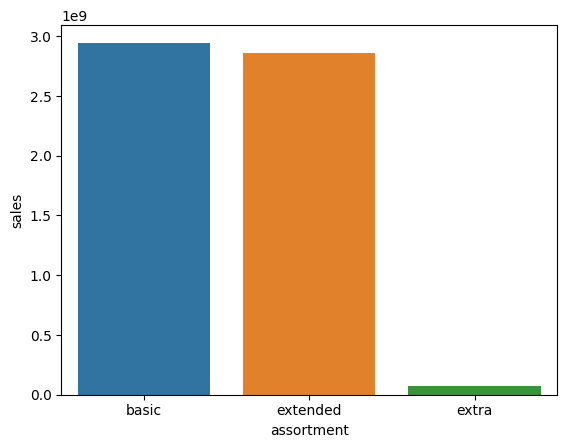

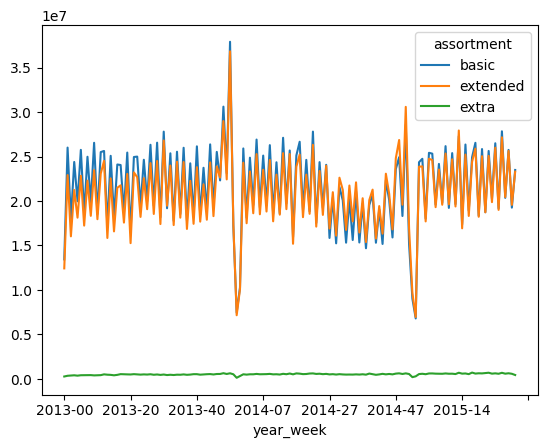

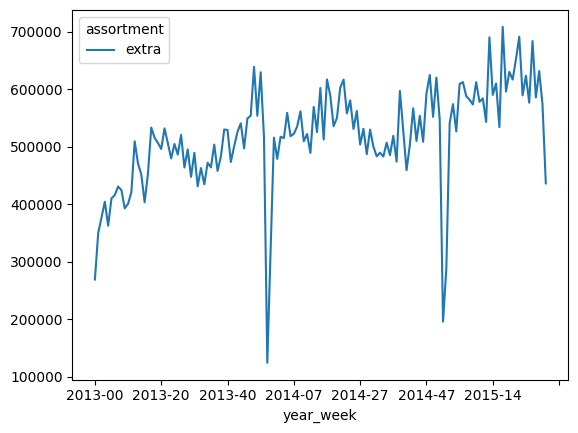

In [ ]:
# Hipótese 1. Lojas com maior sortimento(mix de produtos) deveriam vender mais.
#Lojas com maior sortimento vendem menos

aux1=df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2=df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()


aux3=aux2[aux2['assortment'] ==  'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

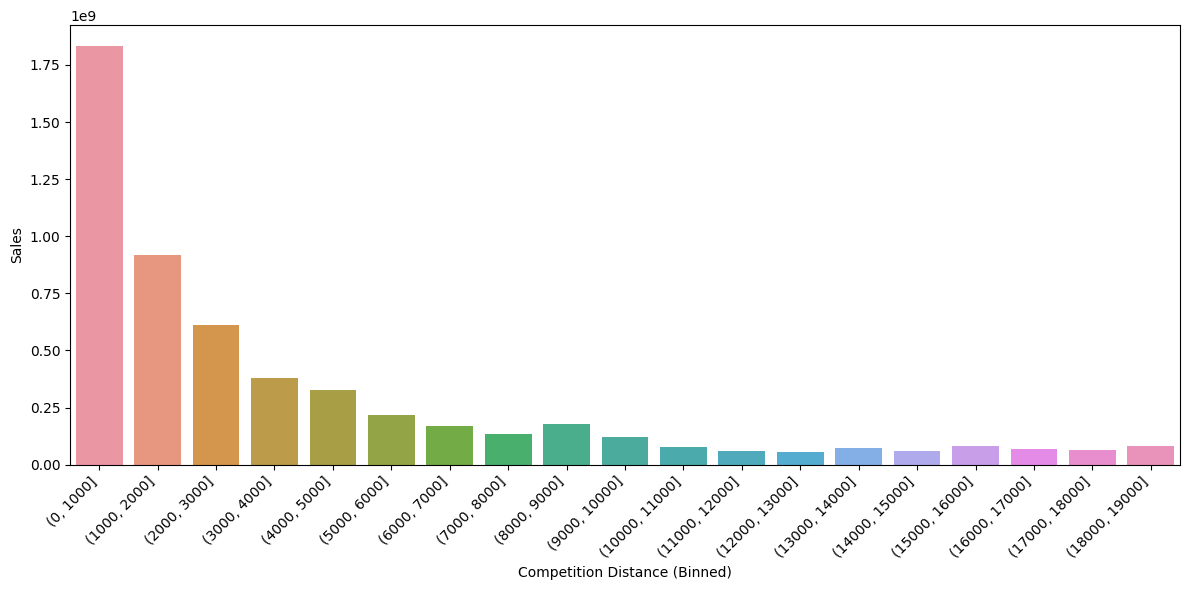

In [ ]:
# Hipótese 2. Lojas com competidores mais próximos deveriam vender menos.
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.figure(figsize=(12, 6))  # Ajuste o tamanho da figura conforme necessário

ax = sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Ajuste a orientação do rótulo do eixo x

plt.xlabel('Competition Distance (Binned)')
plt.ylabel('Sales')

plt.tight_layout()  # Ajusta o espaçamento entre os elementos do gráfico

plt.show()

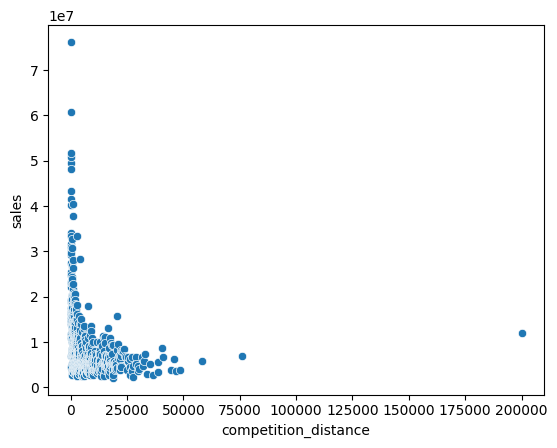

In [ ]:
# Gráfico de disperção
aux1=df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

<ipython-input-58-88f9254433ff>:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'), annot=True)


<Axes: >

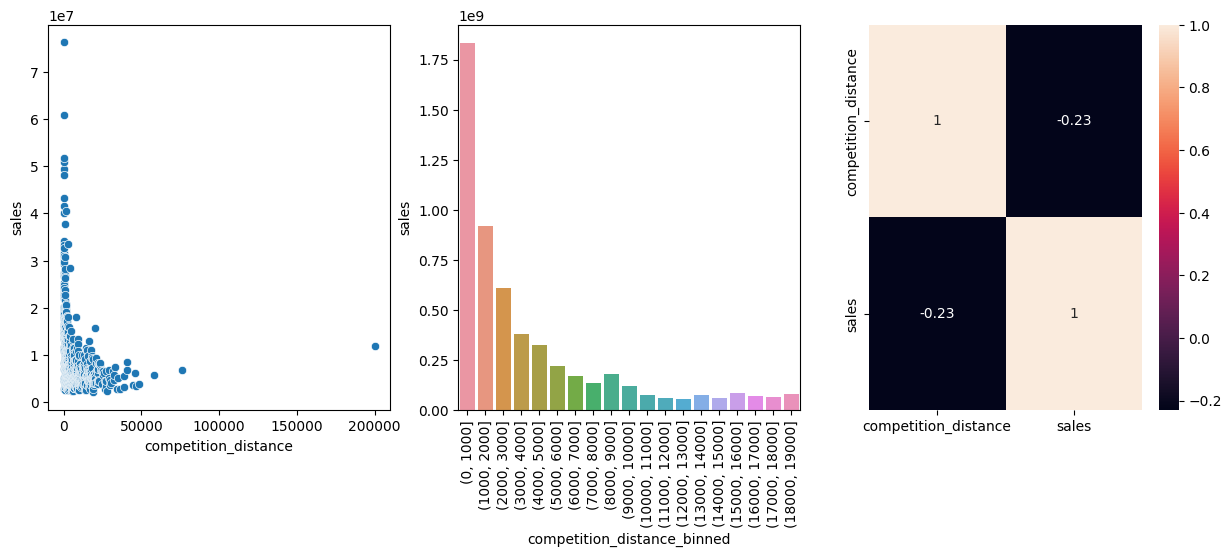

In [ ]:
#grafico que mede a força da correlação entre a compettion_distance e as vendas

aux1=df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins=list(np.arange(0,20000,1000))
aux1['competition_distance_binned']=pd.cut(aux1['competition_distance'], bins=bins)
aux2=aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)


#heat map e o argumento é a correlação
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

##FALSA: Lojas com competiodores proximos vendem MAIS

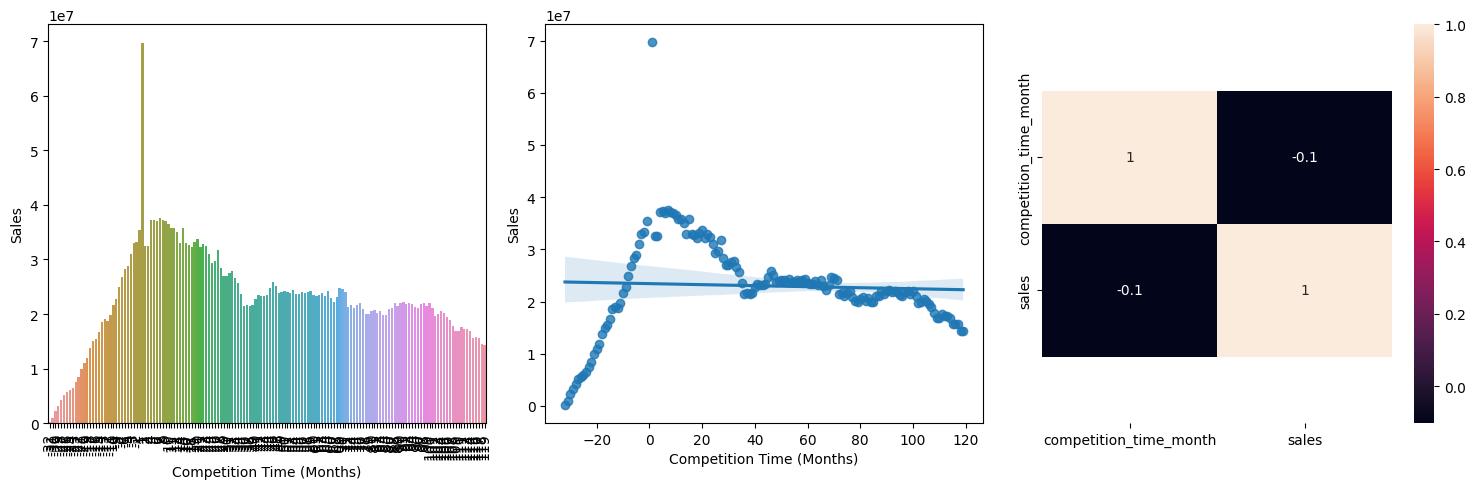

In [ ]:
# Hipótese 3. Lojas com competidores à mais tempo deveriam vender mais.
## FALSO.Quanto mais recentes as competições, maiores as vendas
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)
plt.xlabel('Competition Time (Months)')
plt.ylabel('Sales')

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)
plt.xlabel('Competition Time (Months)')
plt.ylabel('Sales')

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom + 0.5, top - 0.5)

plt.tight_layout()

plt.show()

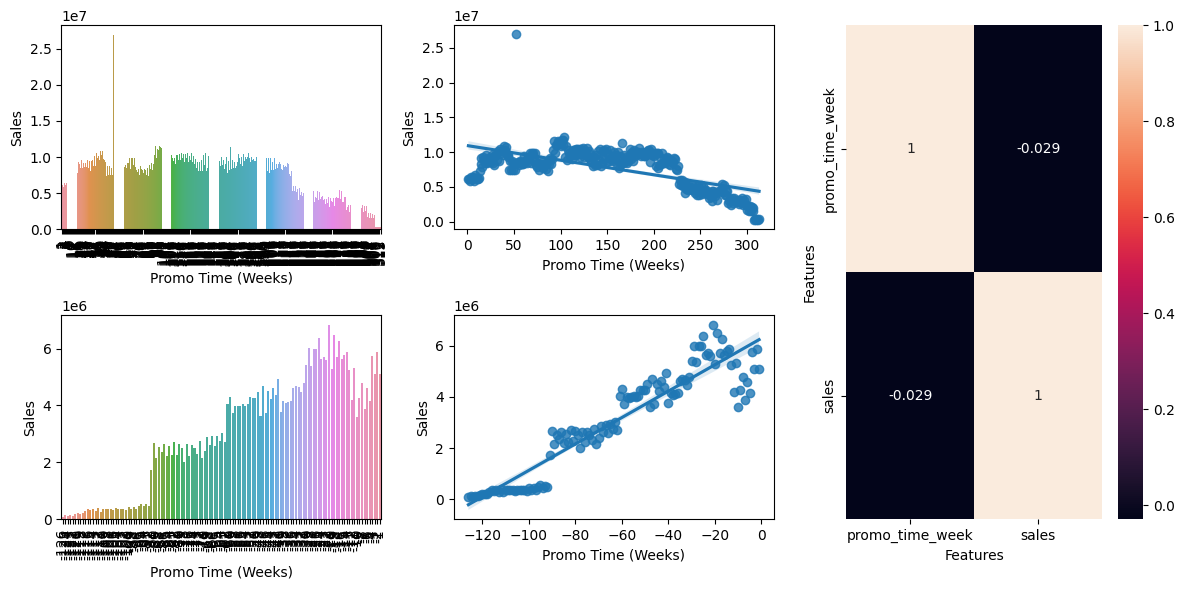

In [ ]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()


plt.figure(figsize=(12, 6))  # Ajuste o tamanho da figura conforme necessário

grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]  # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)
plt.xlabel('Promo Time (Weeks)')
plt.ylabel('Sales')


plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)
plt.xlabel('Promo Time (Weeks)')
plt.ylabel('Sales')

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]  # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)
plt.xlabel('Promo Time (Weeks)')
plt.ylabel('Sales')

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)
plt.xlabel('Promo Time (Weeks)')
plt.ylabel('Sales')

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.xlabel('Features')
plt.ylabel('Features')

plt.tight_layout()  # Ajusta o espaçamento entre os subplots

plt.show()

In [ ]:
# 6. Lojas com mais promoções consecutivas deveriam vender mais.

#FALSA pois lojas com mais promoções consecutivas vendem menos
df4[['promo','promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


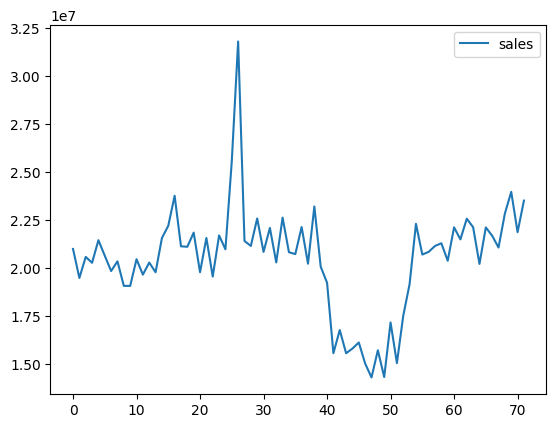

In [ ]:
aux1=df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux1.plot()

aux2=df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['TRadicional & Extendida', 'Extendida']);

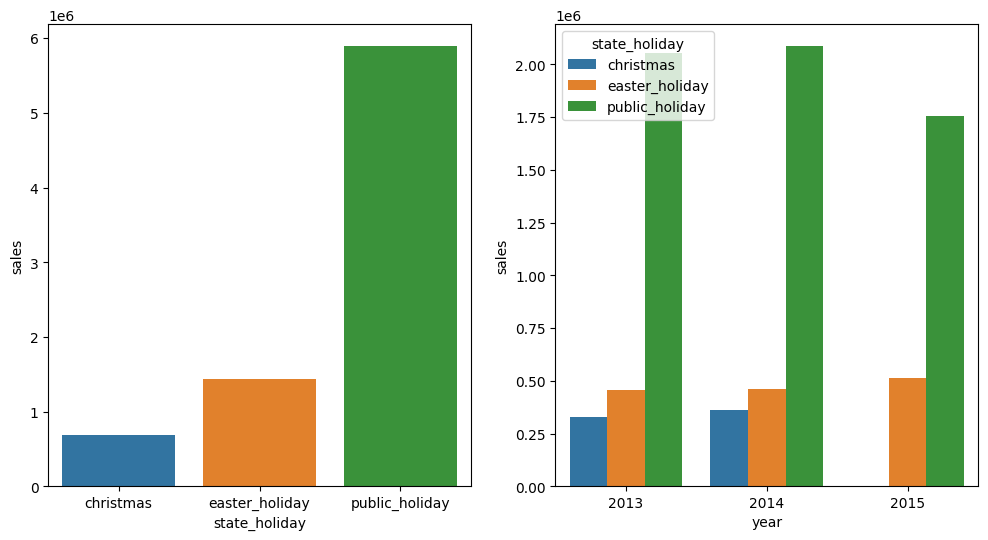

In [ ]:
# 7. Lojas abertas durante o feriado do Natal deveriam vender mais.
#FALSA porque lojas abertas durante o natal vendem menos
aux=df4[df4['state_holiday'] != 'regular_day']

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
aux1=aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2=aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday',data=aux2);

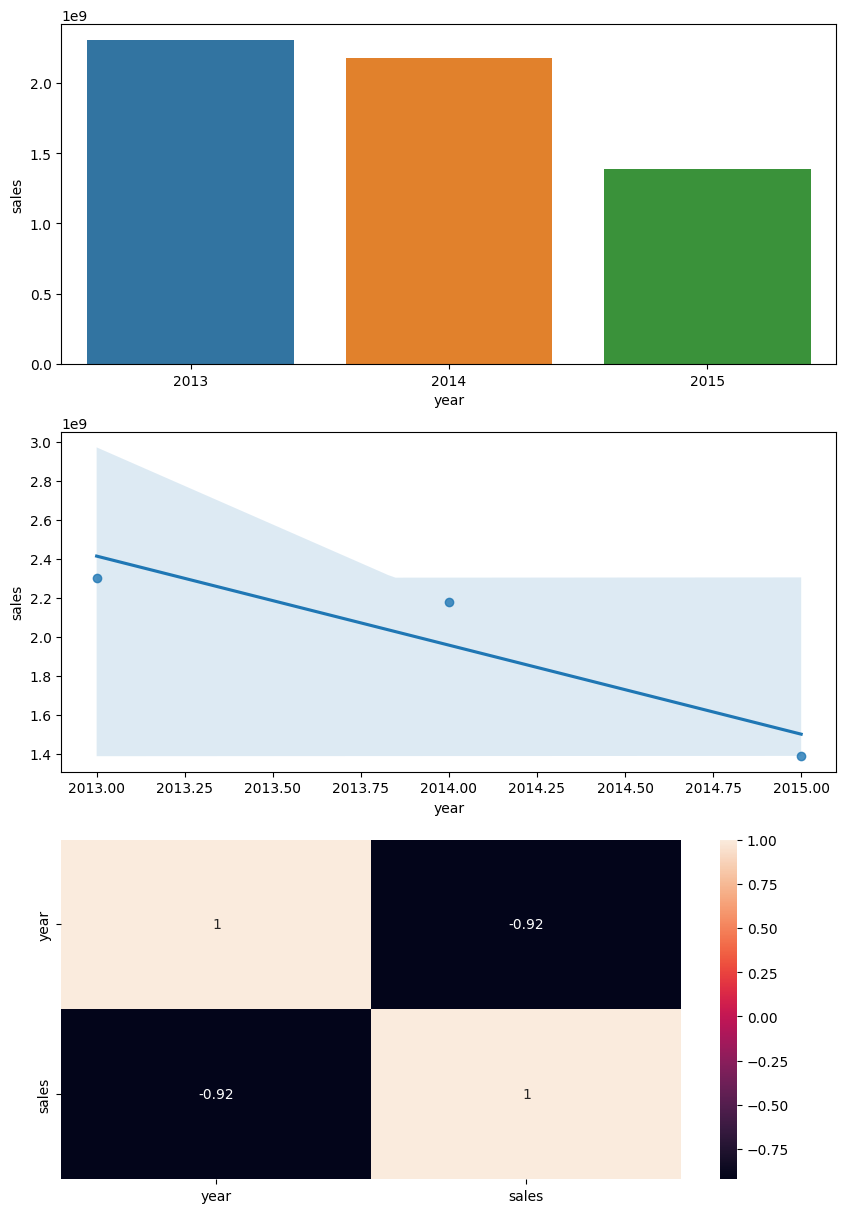

In [ ]:
#.8. Lojas deveriam vender mais ao longo dos anos
#FALSA Lojas vendem menos ao longo dos anos
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.figure(figsize=(10, 15))

plt.subplot(3, 1, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(3, 1, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(3, 1, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

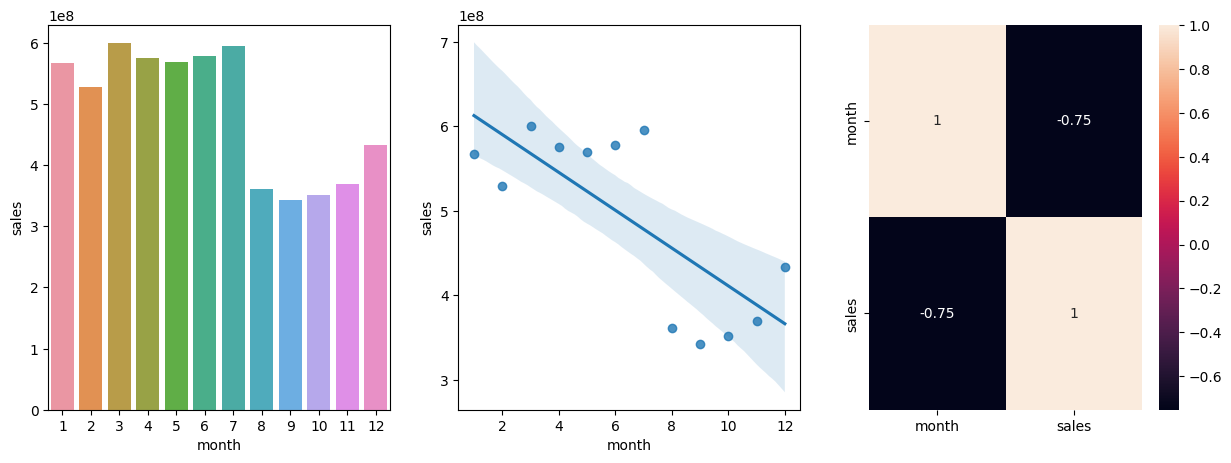

In [ ]:
# 9. Lojas deveriam vender mais no segundo semestre do ano.
#FALSA, vendem menos no segundo sementre do ano
aux1=df4[['month','sales']].groupby('month').sum().reset_index()
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

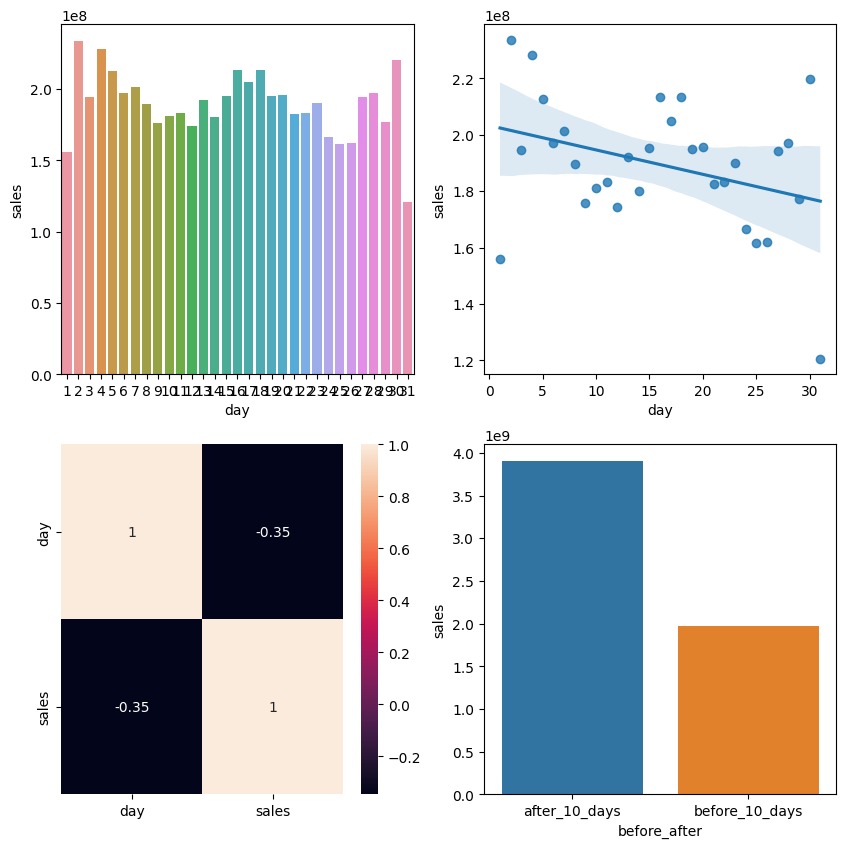

In [ ]:
# 10. Lojas deveriam vender mais depois do dia 10 de cada mês.
#verdadeira, as lojas vendem mais depois do dia 10
aux1=df4[['day','sales']].groupby('day').sum().reset_index()
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

plt.subplot(2,2,4)
aux1['before_after']=aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days' )
aux2=aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

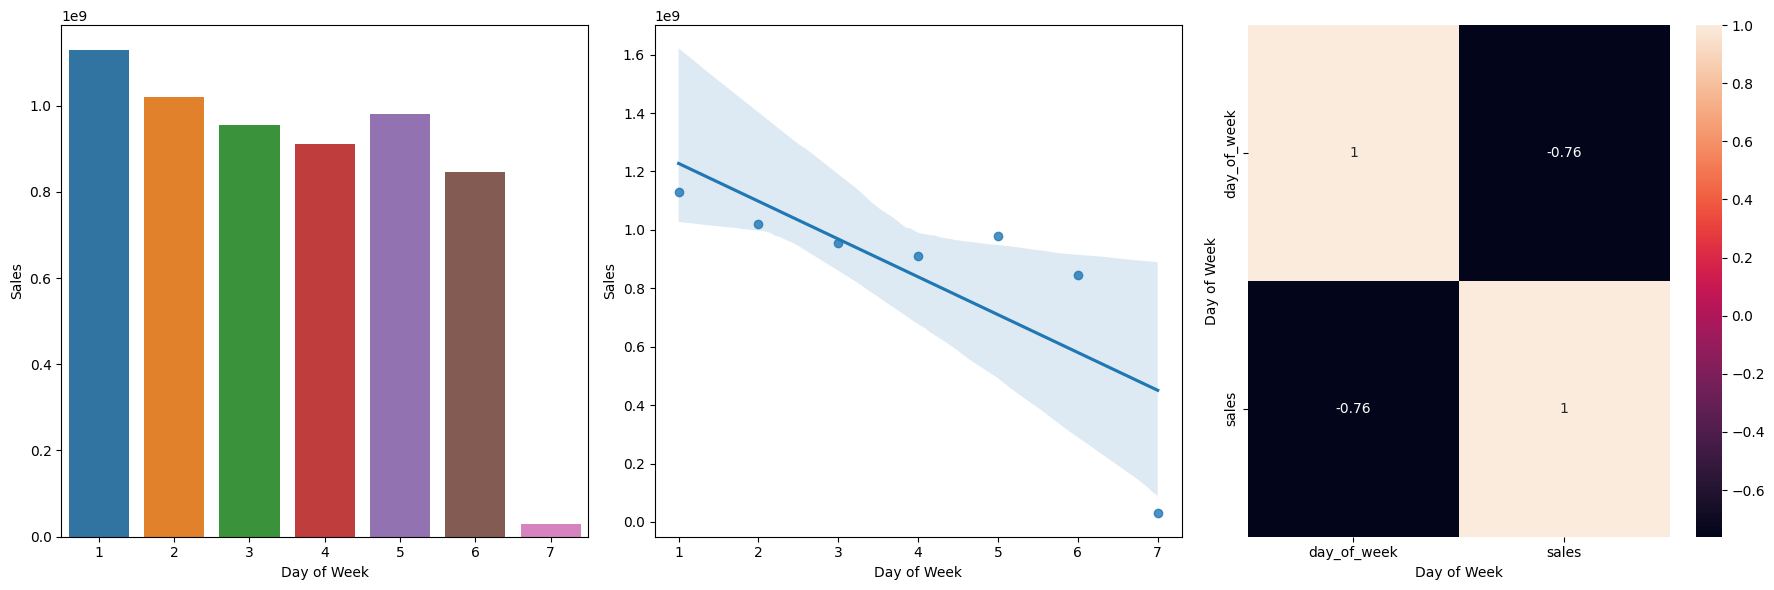

In [ ]:
# 11.Lojas deveriam vender menos aos finais de semana.
#Verdade.  Lojas vendem MENOS nos FINAIS DE SEMANA.
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(18, 6))  # Ajuste o tamanho da figura conforme necessário

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)
plt.xlabel('Day of Week')
plt.ylabel('Sales')

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)
plt.xlabel('Day of Week')
plt.ylabel('Sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.xlabel('Day of Week')
plt.ylabel('Day of Week')

plt.tight_layout()  # Ajusta o espaçamento entre os subplots

plt.show()

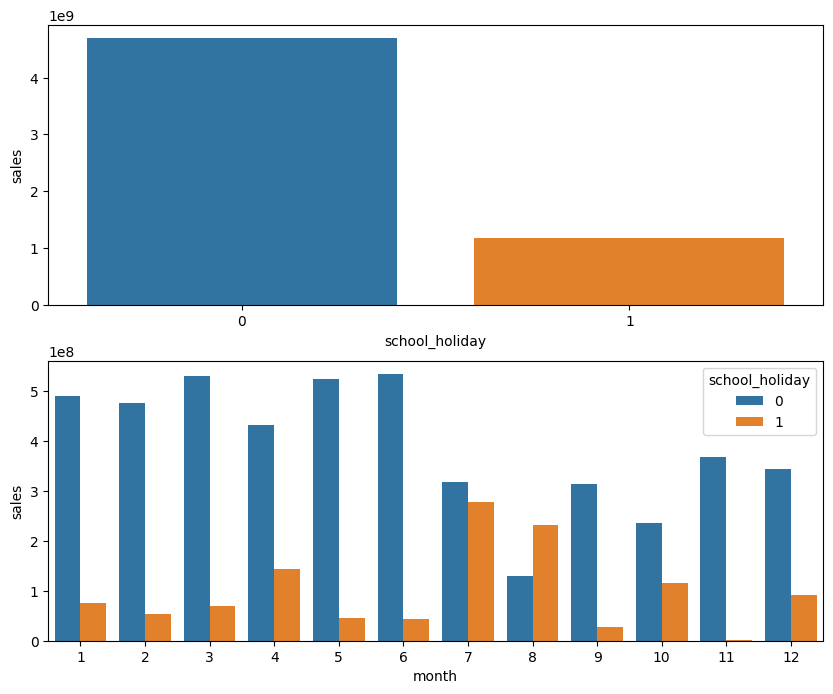

In [ ]:
#12. Lojas deveriam vender menos durante os feriados escolares
#VERDADEIRA Lojas vendem menos durante os feriados escolares, exceto em Julho e Agosto.

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)
plt.show()

### 4.2.1 Hypotesis Resume


In [ ]:
tab = [
    ['Hypotesis', 'Conclusion', 'Relevance'],
    ['H1', 'False', 'Low'],
    ['H2', 'False', 'Medium'],
    ['H3', 'False', 'Medium'],
    ['H4', 'False', 'Low'],
    ['H5', '-', '-'],
    ['H6', 'False', 'Low'],
    ['H7', 'False', 'Medium'],
    ['H8', 'False', 'High'],
    ['H9', 'False', 'High'],
    ['H10', 'True', 'High'],
    ['H11', 'True', 'High'],
    ['H12', 'True', 'Low'],
      ]
print(tabulate(tab, headers='firstrow'))

Hypotesis    Conclusion    Relevance
-----------  ------------  -----------
H1           False         Low
H2           False         Medium
H3           False         Medium
H4           False         Low
H5           -             -
H6           False         Low
H7           False         Medium
H8           False         High
H9           False         High
H10          True          High
H11          True          High
H12          True          Low


## 4.3. Multivariate analysis

### 4.3.1. Numerical Attributes

<Axes: >

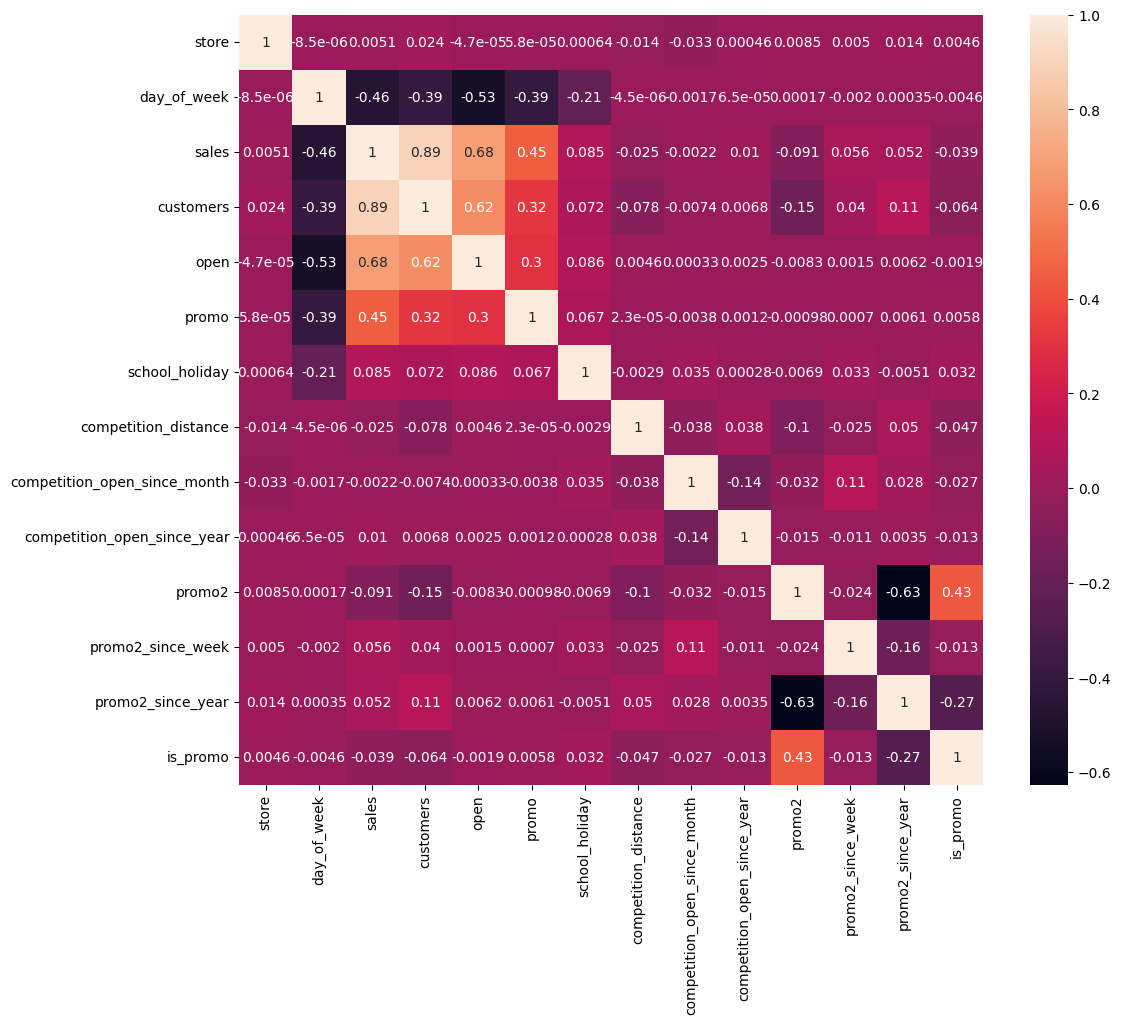

In [ ]:
correlation=num_attributes.corr(method='pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True)

### 4.3.2. Categorical Attributes

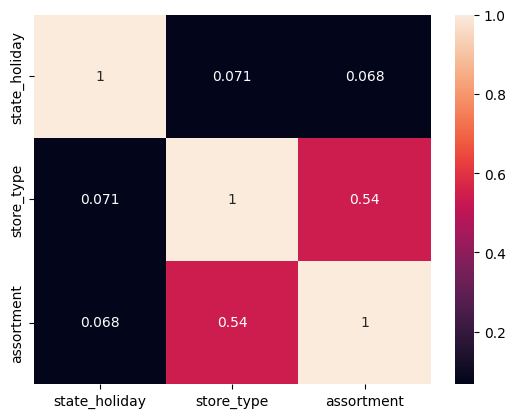

In [ ]:
# Selecionando somente Dados Categóricos
cat = df4.select_dtypes(include='object')

# Calcula Cramer V
a1 = cramer_v(cat['state_holiday'], cat['state_holiday'])
a2 = cramer_v(cat['state_holiday'], cat['store_type'])
a3 = cramer_v(cat['state_holiday'], cat['assortment'])

a4 = cramer_v(cat['store_type'], cat['state_holiday'])
a5 = cramer_v(cat['store_type'], cat['store_type'])
a6 = cramer_v(cat['store_type'], cat['assortment'])

a7 = cramer_v(cat['assortment'], cat['state_holiday'])
a8 = cramer_v(cat['assortment'], cat['store_type'])
a9 = cramer_v(cat['assortment'], cat['assortment'])

# Dataset Final
df = pd.DataFrame({'state_holiday': [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9],
                  })
df = df.set_index(df.columns)

# Mapa de Calor para verificar a correlação entre as variáveis categóricas
sns.heatmap(df, annot=True);

# 5.0. DATA PREPARATION

In [38]:
df5 = df4.copy()


## 5.1. Normalization

Foi Realizada a observação das variáveis numéricas, no item 4.1.2. e concluímos que não temos nenhuma variável com uma distribuição normal (Gaussiana). Dessa forma, não será feita a normalização de nenhuma variável.

## 5.2. Rescaling

In [ ]:
a = df5.select_dtypes(include=['int64', 'float64'])

<Axes: >

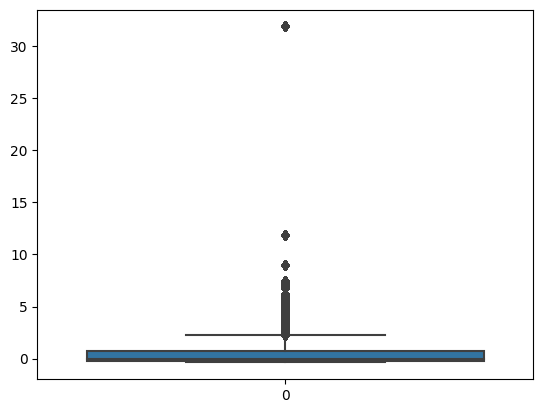

In [ ]:
sns.boxplot(df5['competition_distance'])

<Axes: >

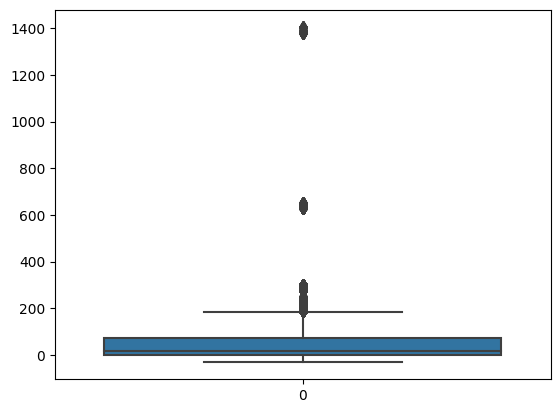

In [ ]:
sns.boxplot(df5['competition_time_month'])

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [81]:
import os

# Caminho das pastas
base_folder = '/content/drive/MyDrive/repositório'
data_science_folder = 'DataScienceProd'
parameter_folder = 'parameter'


# Criação das pastas
os.makedirs(os.path.join(base_folder, data_science_folder, parameter_folder), exist_ok=True)

In [82]:
model_folder = 'model'

# Criação das pastas
os.makedirs(os.path.join(base_folder, data_science_folder, model_folder), exist_ok=True)

In [42]:
mms=MinMaxScaler()
rs=RobustScaler()
#competition distance
df5['competition_distance']=rs.fit_transform(df5[['competition_distance']].values)

#competition time month
df5['competition_time_month']=rs.fit_transform(df5[['competition_time_month']].values)

#promo time week#outliers não sao tao grandes, por isso usar min max scaler
df5['promo_time_week']=mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year']=mms.fit_transform(df5[['year']].values)

In [43]:

# Salvando os scalers com pickle
pickle.dump(rs, open('/content/drive/MyDrive/repositório/DataScienceProd/parameter/competition_distance_scaler.pkl', 'wb'))
pickle.dump(rs, open('/content/drive/MyDrive/repositório/DataScienceProd/parameter/competition_time_month_scaler.pkl', 'wb'))
pickle.dump(mms, open('/content/drive/MyDrive/repositório/DataScienceProd/parameter/promo_time_week_scaler.pkl', 'wb'))
pickle.dump(mms, open('/content/drive/MyDrive/repositório/DataScienceProd/parameter/year_scaler.pkl', 'wb'))

## 5.3 Transformação

### 5.3.1 Encoding

In [44]:
df5['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

In [45]:
#State_holiday -  One Hot Encoding
df5=pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

In [46]:
# Store_type- label encoding
le=LabelEncoder()
df5['store_type']=le.fit_transform(df5['store_type'])
pickle.dump(le, open('/content/drive/MyDrive/repositório/DataScienceProd/parameter/store_type_scaler.pkl', 'wb'))

In [47]:
# assortment- ordinal encoding
assortment_dict={'basic': 1, 'extra':2, 'extended': 3}
df5['assortment']=df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [48]:
df5['sales']=np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [49]:
#month
df5['month_sin']=df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos']=df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))

#day
df5['day_sin']=df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos']=df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))

#week of year
df5['week_of_year_sin']=df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['week_of_year_cos']=df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/12)))

#day of week
df5['day_of_week_sin']=df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos']=df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))

# 6 FEATURE SELECTION


In [50]:
df6=df5.copy()

## 6.1. Split dataframe into training and test dataset

In [51]:
cols_drop = [
    'week_of_year', 'day', 'month', 'day_of_week', 'promo_since',
    'competition_since', 'year_week'
]
df6 = df6.drop(cols_drop, axis=1)

In [52]:
df6[['store', 'date'
     ]].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(
         days=7 * 6)

Timestamp('2015-06-19 00:00:00')

In [53]:
# training dataset

x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# test dataset

x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print('Training Min Date: {}'.format(x_train['date'].min()))
print('Training Max Date: {}'.format(x_train['date'].max()))
print('\nTest Min Date: {}'.format(x_test['date'].min()))
print('Test Max Date: {}'.format(x_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [ ]:
#  training and test dataset for boruta
# x_train_n = x_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

#  define RandoForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

#  define Boruta
# boruta = BorutaPy (rf , n_estimators = 'auto' , verbose = 2 ,random_state = 42).fit(x_t

## 6.2.1 Best Features from Boruta

In [ ]:
# cols_selected = boruta.support_.tolist()

#  best features
# x_train_fs = x_train.drop(['date','sales'] , axis = 1)
# cols_selected_boruta = x_train_fs.iloc[: , cols_selected].columns.to_list()

#  not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns , cols_selected_borut

## 6.3. Manual Feature Selection

In [54]:
cols_selected_boruta = [
    'store', 'promo', 'store_type', 'assortment', 'competition_distance',
    'competition_open_since_month', 'competition_open_since_year', 'promo2',
    'promo2_since_week', 'promo2_since_year', 'competition_time_month',
    'promo_time_week', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'day_of_week_sin', 'day_of_week_cos', 'week_of_year_cos',
    'week_of_year_sin'
]

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [ ]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'week_of_year_cos',
 'week_of_year_sin']

# 7.0. MACHINE LEARNING MODELLING

In [55]:
X_train = x_train[cols_selected_boruta]
X_test = x_test[cols_selected_boruta]

# Time series Data Preparation
x_training = x_train[cols_selected_boruta_full]

## 7.1. Avarage Model

In [ ]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error('Avarage Model', np.expm1(y_test),
                           np.expm1(yhat_baseline))

In [ ]:
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [ ]:
# # model
lr = LinearRegression().fit(X_train, y_train)

# # prediction
yhat_lr = lr.predict(X_test)

 # perfomance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))

In [ ]:
 lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1892.034326,0.298105,2693.374641


### 7.2.1. Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv=cross_validation(x_training,5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2104.3 +/- 287.96,0.31 +/- 0.02,2975.99 +/- 456.57


## 7.3. Linear Regression Regularized Model - Lasso

In [ ]:
# # model
# lasso = Lasso(alpha = 0.01).fit(X_train, y_train)

# # prediction
# yhat_lasso = lasso.predict(X_test)

# # perfomance
# lr_result_lasso = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lasso))

In [ ]:
# lr_result_lasso

### 7.3.1. Lasso - Cross Validation

In [ ]:
# model = Lasso(alpha=0.01)
# lasso_cv = cross_validation('Lasso',x_training , 5 , model)
# lasso_cv

## 7.4. Random Forest Regressor Model

In [ ]:
# # model
# RFR = RandomForestRegressor(n_estimators=100 , n_jobs= -1, random_state=42).fit(X_train, y_train)

# # prediction
# yhat_RFR = RFR.predict(X_test)

# # perfomance
# lr_result_RFR = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_RFR))

In [ ]:
# lr_result_RFR

### 7.4.1. Random Forest Regressor Model - Cross Validation

In [ ]:
# model = RandomForestRegressor(n_estimators=100 , n_jobs= -1, random_state=42)
# random_cv = cross_validation('Random Forest',x_training , 5 , model)
# random_cv

## 7.5. XGBoost Regressor Model

In [56]:
# model
xb = xgb.XGBRegressor(objective='reg:squarederror',
                      n_estimators=100 ,
                      eta = 0.01 ,
                      max_depth = 10 ,
                      subsample = 0.7,
                      colsample_bytree = 0.9).fit(X_train, y_train)

# prediction
yhat_xb = xb.predict(X_test)

# perfomance
lr_result_xb = ml_error('XGboost Regressor', np.expm1(y_test), np.expm1(yhat_xb))

In [ ]:
lr_result_xb

,Model Name,MAE,MAPE,RMSE
0,XGboost Regressor,6683.139886,0.949428,7330.055725


### 7.5.1. XGBoost Regressor Model - Cross Validation

In [ ]:
xgb_result_cv=cross_validation(x_training,5, 'XGBoost Regressor', xb, verbose=True)
xgb_result_cv

Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.6 +/- 594.15,0.95 +/- 0.0,7715.78 +/- 694.63


## 7.6. Compare Model's Perfomance

### 7.6.1. Single Perfomance - Cross Validation

In [ ]:
# moddeling_result = pd.concat([baseline_result , lr_result , lr_result_lasso , lr_result_RFR, lr_result_xb  ])
# moddeling_result.sort_values('RMSE')

### 7.6.2. Real Perfomance - Cross Validation

In [ ]:
# moddeling_result_cv = pd.concat([lr_cv , lasso_cv , random_cv , xgb_cv ])
# moddeling_result_cv

#8.0. HYPERPARAMETER FINE TUNING

In [ ]:
# param = {
#          'n_estimators':[1500 , 1700 ,2500 , 3000 , 3500],
#          'eta' : [0.01 , 0.03],
#          'max_depth' : [3 , 5 , 9],
#          'subsample' : [0.1 ,0.5 ,0.7],
#          'colsample_bytree' : [0.3 , 0.7 , 0.9] ,
#          'min_child_weight': [3 , 8 , 15]
#          }

# MAX_EVAL = 5

In [ ]:
# final_result = pd.DataFrame()

# for i in range (MAX_EVAL):
#     # choose valies for parameters randomly
#     hp = {k : random.sample(v,1)[0]for k,v in param.items()}
#     print(hp)

#     # model
#     xb = xgb.XGBRegressor(objective='reg:squarederror',
#                           n_estimators=hp['n_estimators'] ,
#                           eta = hp['eta'] ,
#                           max_depth = hp['max_depth'] ,
#                           subsample = hp['subsample'],
#                           colsample_bytree = hp['colsample_bytree'],
#                           min_child_weight=hp['min_child_weight'])

#     # perfomance
#     result = cross_validation('XGboost Regressor',x_training , 5 , xb , verbose = True)
#     final_result = pd.concat([final_result , result])

# final_result

## 8.2. Final Model

In [57]:
param_tuned = {
               'n_estimators': 3500,
               'eta' : 0.01 ,
               'max_depth' : 9 ,
               'subsample' : 0.5,
               'colsample_bytree' : 0.9 ,
               'min_child_weight': 15
              }

In [62]:
# model
xb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                      n_estimators=param_tuned['n_estimators'] ,
                      eta = param_tuned['eta'] ,
                      max_depth = param_tuned['max_depth'] ,
                      subsample = param_tuned['subsample'],
                      colsample_bytree = param_tuned['colsample_bytree'],
                      min_child_weight=param_tuned['min_child_weight']).fit(X_train, y_train)


In [63]:
# prediction
yhat_xgb_tuned = xb_tuned.predict(X_test)

# perfomance
xgb_result_tuned = ml_error('XGboost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGboost Regressor,685.883268,0.101111,989.789961


In [64]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.006781884097739495

# 9.0 TRADUCAO E INTERPRETACAO DO ERRO

In [67]:
df9 = x_test[cols_selected_boruta_full];

# rescale
df9['sales'] = np.expm1(df9['sales']);
df9['predictions'] = np.expm1(yhat_xgb_tuned);

<ipython-input-67-60dd7f8dfd67>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales']);
<ipython-input-67-60dd7f8dfd67>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned);


## 9.1 Business Performance

In [68]:
# sum of predictions

df91 = df9[['store' , 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales' , 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'] , x['predictions'])).reset_index().rename(columns = {0:'MAE'})
df9_aux2 = df9[['store', 'sales' , 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'] , x['predictions'])).reset_index().rename(columns = {0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1 , df9_aux2 , how = 'inner' , on = 'store')
df92 = pd.merge(df91 , df9_aux3 , how = 'inner', on = 'store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns

df92 = df92[['store' , 'predictions','worst_scenario' , 'best_scenario' , 'MAE','MAPE']]

In [69]:
df92.sort_values('MAPE' , ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106129.226562,102809.913266,109448.539859,3319.313297,0.561599
908,909,236698.078125,228957.602114,244438.554136,7740.476011,0.527507
594,595,339786.125000,334666.479492,344905.770508,5119.645508,0.351221
875,876,209446.484375,205426.974429,213465.994321,4019.509946,0.313547
273,274,190647.828125,189189.126397,192106.529853,1458.701728,0.247843


In [70]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1012,1013,149041.25000,148463.540283,149618.959717,577.709717,0.165346
40,41,231781.62500,231003.679120,232559.570880,777.945880,0.139808
455,456,224447.78125,223962.951106,224932.611394,484.830144,0.093441
796,797,191450.40625,191048.498364,191852.314136,401.907886,0.082029


<Axes: xlabel='store', ylabel='MAPE'>

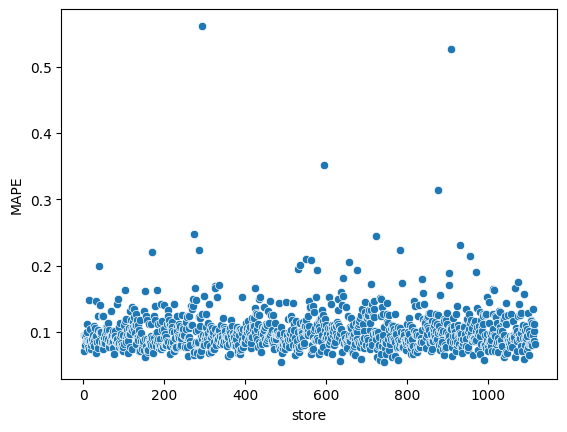

In [71]:
sns.scatterplot( x = 'store' , y = 'MAPE' , data =df92)

## 9.2 Total Performance

In [72]:
df93 = df92[['predictions' , 'worst_scenario' , 'best_scenario']].apply(lambda x : np.sum(x) , axis = 0).reset_index().rename(columns = {'index' : 'Scenario' , 0:'Values'} )
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$285,795,456.00"
1,worst_scenario,"R$285,027,518.71"
2,best_scenario,"R$286,563,363.53"


## 9.3 Machine Learning Performance

In [73]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<ipython-input-73-0c99df7e7a2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
<ipython-input-73-0c99df7e7a2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


<ipython-input-99-82d3d1e55db6>:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df9['error'])


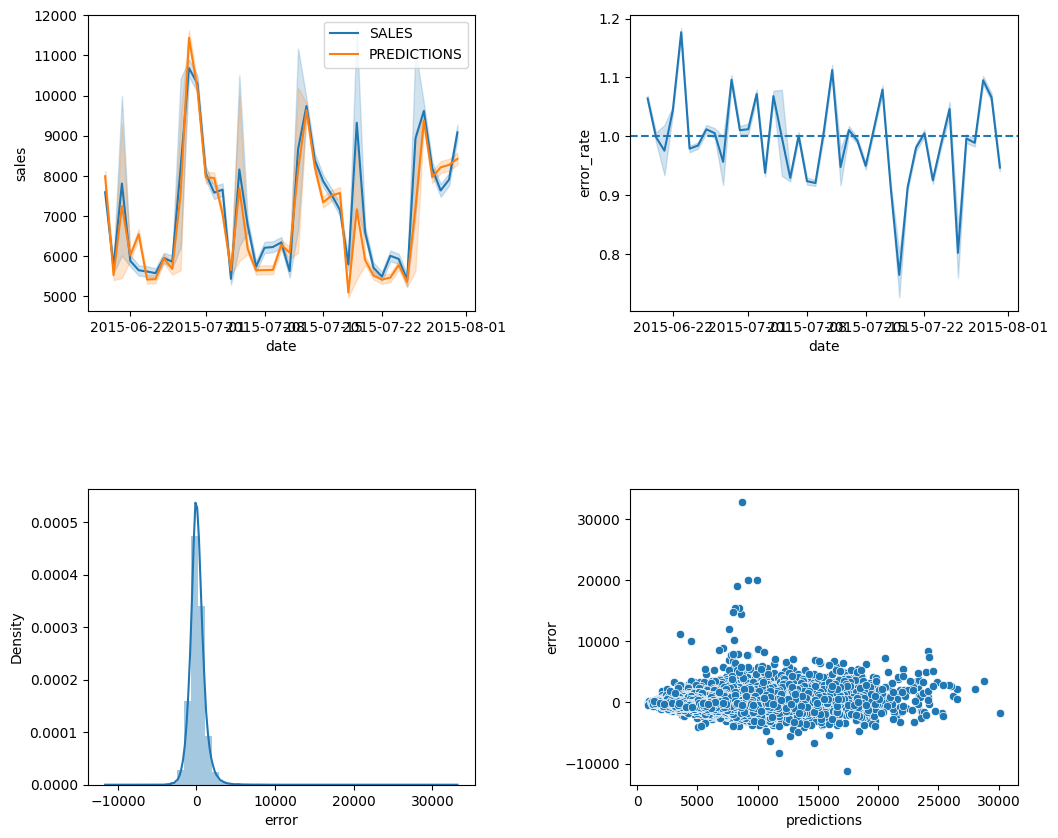

In [99]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(x=df9['predictions'], y=df9['error'])

plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.show()


# 10.0 DEPLOY MODEL TO PRODUCTION

In [83]:
# Save Trained Model
pickle.dump(xgb_result_tuned, open('/content/drive/MyDrive/repositório/DataScienceProd/model/model_rossmann.pkl', 'wb'))

## 10.1 Rossmann Class

In [75]:
import pickle

class Rossmann(object):
    def __init__(self):
        self.home_path = '/content/drive/MyDrive/repositório/DataScienceProd/'
        self.label_encoder = pickle.load(open(self.home_path + 'parameter/label_encoder.pkl', 'rb'))
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))


    def data_cleaning(self, df1):


        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase , cols_old))

        # rename

        df1.columns = cols_new

        ### 1.3. Data Types

        df1['date'] = pd.to_datetime(df1['date'])



        ### 1.5. Fillout NA

        df1['competition_distance'].max()

        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month']= df1.apply(lambda x :x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'] , axis = 1)

        # competition_open_since_year
        df1['competition_open_since_year']= df1.apply(lambda x :x['date'].year  if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'] , axis = 1)

        # promo2_since_week
        df1['promo2_since_week']= df1.apply(lambda x :x['date'].week  if math.isnan(x['promo2_since_week']) else x['promo2_since_week'] , axis = 1)

        # promo2_since_year
        df1['promo2_since_year']= df1.apply(lambda x :x['date'].year  if math.isnan(x['promo2_since_year']) else x['promo2_since_year'] , axis = 1)

        # promo_interval
        month_map = {1 : 'Jan' ,2 : 'Fev' ,3 : 'Mar' ,4 : 'Apr' ,5 : 'May' ,6 : 'Jun' ,7 : 'Jul' ,8 : 'Aug' ,9 : 'Set' ,10 : 'Out' ,11 : 'Nov' ,12 : 'Dez' }

        df1['promo_interval'].fillna(0 , inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0 , axis = 1)

        ### 1.6. Change Types
        #competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
        #promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

        return df1


    def feature_engineer(self , df2):


        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x : datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day=1 ), axis = 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) +'-'+ df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x : datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        #assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        #State Holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0. FILTRAGEM DE VARIÁVEIS

        ### 3.1. Filtragem das Linhas

        df2 = df2[df2['open'] != 0]

        ### 3.2. Selecao das Colunas

        cols_drop = [ 'open','promo_interval','month_map']
        df2 = df2.drop(cols_drop , axis = 1)

        return df2



    def data_preparation(self,df5):


        # competition_dinstance
        df5['competition_distance']= self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        # competition time month
        df5['competition_time_month'] = self.competition_time_month.fit_transform(df5[['competition_time_month']].values)


        # promo_time_week
        df5['promo_time_week'] = self.promo_time_week.fit_transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## 5.3. Transformacao

        ### 5.3.1. Enconding
        # state_holiday -- one_hot_encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # school_holiday -- ordinal encoding
        df5['school_holiday'] = df5['school_holiday'].map({'regular': 0, 'feriado': 1})

        # store_type -- label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])


        # assortment -- ordinal encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3. Nature Transformation

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

        cols_selected = [  'store', 'promo', 'store_type', 'assortment', 'competition_distance',
                                    'competition_open_since_month', 'competition_open_since_year', 'promo2',
                                    'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                                    'promo_time_week', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                                    'day_of_week_sin', 'day_of_week_cos', 'week_of_year_cos','week_of_year_sin'
                                ]


        return df5[cols_selected]



    def get_prediction(self,model , original_data , test_data):

        # predict
        pred = model.predict(test_data)

        #join pred into the original data_preparation

        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient='records' , date_format='iso')


## 10.2 API Handler

In [89]:
# loading model
model = pickle.load(open(r'/content/drive/MyDrive/repositório/DataScienceProd/model/model_rossmann.pkl', 'rb'))

# initialize API

app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])

def rossman_predict():
    test_json = request.get_json()

    if test_json: # there is data

        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])                      # Unique Example
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())    # Multiple Examples

        # Instantiate Rossmann class
        pipeline = Rossmann()

        # data data_cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # predict
        df_response = pipeline.get_prediction(model , test_raw , df3)

        return df_response


    else:
        return Response('{}', status=200 , mimetype= 'application/json')


if __name__ =='__mains__':
    app.run('0.0.0.0')

## 10.3 API Tester

In [90]:
import pandas as pd

In [91]:
import json
import requests


# loading test dataset
df10 = pd.read_csv(r"testt.csv")

# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )
# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]
# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [92]:
df_test.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
13,20,4,2015-09-17,1.0,1,0,0,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
15,22,4,2015-09-17,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
16,23,4,2015-09-17,1.0,1,0,0,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN
869,20,3,2015-09-16,1.0,1,0,0,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
871,22,3,2015-09-16,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


In [93]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [94]:
# API Call

# url = 'http://localhost:5000/rossmann/predict'
url = 'https://rossmann-model-predic.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post(url, data=data,headers=header)

print('Status Code {}'.format(r.status_code))

Status Code 503


In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d1.head()

In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store number {} will sell R$ {:,.2f} in the next 6 weeks'.format(d2.loc[i,'store'],d2.loc[i,'prediction']))
